# 군집화
이 책의 모든 알고리즘은 **레이블** 이 있는 데이터로 모델을 학습해서 레이블이 없는 데이터의 레이블을 예측한다는 점에서 **지도 학습(supervised learning)** 알고리즘이라고 한다.

하지만 **군집화(clustering)** 는 레이블이 없는 데이터를 사용하는 또는 레이블이 있더라도 그것을 사용하지 않는 **비지도 학습(unsupervised learning)** 의 일종이다. 

## 20.1 군집화 감 잡기
대부분의 데이터는 어떤 방식으로든 **군집(cluster)** 을 이룬다. 

e.g. 백만장자들의 거주지 데이터를 보면 보통 베버리힐스나 맨해튼 쪽에서 군집을 이룬다. 

**우리가 그동안 살펴본 문제와는 달리, 군집화를 할 때는 '정답'이라는 것이 없다.**

군집 평기에 사용되는 지수가 무엇이냐에 따라 더 최적인 군집이 있을 수는 있지만, 군집에는 자동적으로 레이블이 달리지도 않는다.
데이터 하나하나 개별적으로 들여다 보며 직접 레이블을 달아야 한다.

## 20.2 모델
각 입력값은 항상 그렇듯 숫자로 구성된 d-차원 공간의 벡터이다. 우리의 **목표**는 **유사한 입력값끼리 묶어서 군집을 찾고, 각 군집에 맞는 대푯값을 찾는 것**이다.

e.g. 사용자들의 블로깅 패턴을 이해하기 위해, 수치형 벡터로 표현된 블로그 포스트의 제목을 군집화해 볼 수도 있다. 

가장 간단한 군집화 방법 중 하나는 군집의 개수 k를 미리 정해 두는 k-means이다.

이 알고리즘은 각 데이터 포인트가 속한 군집의 중심적(mean)과 거리의 제곱 합을 최소화시키며 데이터를 $S_1,..., S_k$과 같은 군집으로 나눈다.

n개의 데이터 포인트를 k개의 군집으로 할당하는 방법은 아주 다양하다. 바꿔 말하면, 최적의 군집을 찾는 것은 무척 어렵다. 

아래는 반복 연산으로 꽤 괜찮은 군집을 찾는 방법이다.

1. d-차원의 공간에서 임의의 점 k개를 찍고, 이들을 각 군집의 중심점으로 간주한다.
2. 각 데이터 포인트에서 가장 가까운 중심점을 기준으로 군집을 정한다.
3. 소속된 군집이 바뀐 데이터 포인트가 하나라도 없다면 군집을 기록하고 종료한다.
4. 소속된 군집이 바뀐 데이터 포인트가 하나라고 있다면 중심점을 다시 계산하고 2단계로 돌아간다.

선형대수에서 만든 vector_mean을 사용하면 이렇게 동작하는 클래스를 간단하게 만들 수 있다.

아래 코드는 두 벡터의 좌표상 차이를 측정하는 함수이다. 이 함수는 학습에 사용될 것이다.

In [1]:
from typing import List

Vector = List[float]

def num_differences(v1: Vector, v2: Vector) -> int:
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

In [2]:
assert num_differences([1,2,3], [2,1,3]) == 2
assert num_differences([1,2], [1,2]) == 0

여러 벡터와 그들이 소속된 군집이 주어졌을 때, 해당 군집의 중심점을 계산해 주는 함수도 필요하다. 소속된 데이터 포인트가 아예 없는 군집도 있을 수 있다. 이런 경우 평균을 구할 수 없으니, 임의의 데이터 포인트를 중심점으로 사용하자.

In [3]:
from typing import List

def vector_sum(vectors: List[Vector]) -> Vector:
    """모든 벡터의 각 성분들끼리 더한다."""
    # vectors가 비어있는지 확인
    assert vectors, "no vectors provided"
    
    # 모든 벡터의 길이가 동일한지 확인
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"
    
    # i번째 결과값은 모든 벡터의 i번째 성분을 더한 값
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c: float, v: Vector) -> Vector:
    """모든 성분을 c로 곱하기"""
    return [c * v_i for v_i in v]

def vector_mean(vectors: List[Vector]) -> Vector:
    """각 성분별 평균을 계산"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

In [4]:
def cluster_means(k: int,
                 inputs: List[Vector],
                 assignments: List[int]) -> List[Vector]:
    # cluseters[i]는 군집 i에 해당하는 데이터 포인트를 담는다.
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)
        
    # 군집이 비어 있으면 임의의 데이터 포인트를 사용하자.
    return [vector_mean(cluster) if cluster else random.choice(inputs)
           for cluster in clusters]

군집화 알고리즘을 작성할 준비가 끝났다. 이번에도 tqdm을 써서 진척 상황을 확인할 것이다. 단, 여기서는 코드가 몇 번 수행될지 사전에 알 수 없기 때문에 itertools.count로 무한의 이터러블을 생성한 후 프로세스가 종료되면 return하자.

In [5]:
import itertools
import random
import tqdm

def dot(v: Vector, w: Vector) -> float:
    """v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w),  "vectors must be same length"
    
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

def sum_of_squares(v: Vector) -> float:
    """v_1 * v_1 + ... v_n * v_n"""
    return dot(v,v)

def subtract(v: Vector, w: Vector) -> Vector:
    """각 성분끼리 뺀다."""
    assert len(v) == len(w), "vectors must be the same length"
    
    return [v_i - w_i for v_i, w_i in zip(v, w)]

def squared_distance(v: Vector, w: Vector) -> float:
    """(v_1 - w_1)**2 + ... + (v_n - w_n)**2"""
    return sum_of_squares(subtract(v, w))

In [6]:
class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k  # number of clusters
        self.means = None
        
    def classify(self, input: Vector) -> int:
        """입력 데이터에 가장 인접한 군집의 인덱스를 반환"""
        return min(range(self.k),
                  key=lambda i: squared_distance(input, self.means[i]))
    
    def train(self, inputs: List[Vector]) -> None:
        # 일단 임의로 군집을 할당한다.
        assignments = [random.randrange(self.k) for _ in inputs]
        
        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # 중심점을 구한 후 군집을 새로 할당한다.
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]
                
                # 군집이 바뀐 수를 세고 종료할 것인지를 판단
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return
                
                # 그렇지 않다면 새로 할당된 군집을 저장하고, 새 중심점을 구한다.
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")

## 20.3 예시: 오프라인 모임
사용자들의 거주지 데이터를 기반으로 모두가 만족할 수 있는 모임 장소를 선정하는 것이 목적

In [7]:
inputs: List[List[float]] = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]
random.seed(12)  # 매번 동일한 결과를 얻기 위해서다.
clusterer = KMeans(k=3)
clusterer.train(inputs)
means = sorted(clusterer.means)  # 유닛 테스트를 위해 정렬한다.

changed: 5 / 20: : 1it [00:00, 819.04it/s]


In [8]:
assert len(means) == 3
assert squared_distance(means[0], [-44, 5]) < 1
assert squared_distance(means[1], [-16, -10]) < 1
assert squared_distance(means[2], [18, 20]) < 1

Text(0, 0.5, 'blocks north of city center')

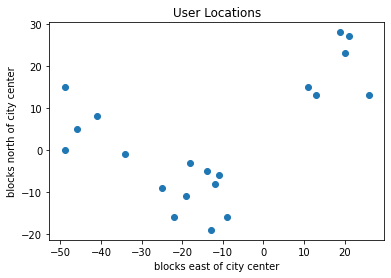

In [9]:
import matplotlib.pyplot as plt
x = [inputs[x_i][0] for x_i in range(len(inputs))]
y = [inputs[x_i][1] for x_i in range(len(inputs))]

plt.scatter(x, y)
plt.title('User Locations')
plt.xlabel('blocks east of city center')
plt.ylabel('blocks north of city center')

[-44, 5], [-16, -10], [18, 20]에 중심점이 있는 군집 세 개를 찾아서 그 위치를 기반으로 모임 장소를 물색해 보았다.

In [10]:
random.seed(0)
clusterer = KMeans(k=2)
clusterer.train(inputs)
means = sorted(clusterer.means)

assert len(means) == 2
assert squared_distance(means[0], [-26, -5]) < 1
assert squared_distance(means[1], [18, 20]) < 1

changed: 4 / 20: : 2it [00:00, 1266.01it/s]


## 20.4 k 값 선택하기
앞의 예시에서는 외부 요인이 k값을 결정했지만, 그런 경우는 보통 드물다. k값을 정할 수 있는 방법은 매우 다양하다. 쉬운 방법 중 하나는 k값에 대해 오차(중심점과 각 데이터 포인트 사이의 거리)의 제곱 합을 그래프로 그리고, 그 그래프가 어디서 꺾이는지 관찰하는 것이다.

In [11]:
import matplotlib.pyplot as plt

def squared_clustering_errors(inputs: List[Vector], k: int) -> float:
    """모든 입력값에 대해 k-means 군집화를 실행하고 오차의 제곱 합을 계산"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]
    
    return sum(squared_distance(input, means[cluster])
              for input, cluster in zip(inputs, assignments))

0it [00:00, ?it/s]
changed: 8 / 20: : 1it [00:00, 879.31it/s]
changed: 2 / 20: : 2it [00:00, 1253.34it/s]
changed: 2 / 20: : 2it [00:00, 787.37it/s]
changed: 2 / 20: : 4it [00:00, 1213.63it/s]
changed: 1 / 20: : 3it [00:00, 1191.90it/s]
changed: 1 / 20: : 5it [00:00, 1237.70it/s]
changed: 4 / 20: : 2it [00:00, 965.87it/s]
changed: 2 / 20: : 3it [00:00, 795.33it/s]
changed: 4 / 20: : 3it [00:00, 795.38it/s]
changed: 1 / 20: : 3it [00:00, 897.37it/s]
changed: 1 / 20: : 3it [00:00, 658.34it/s]
changed: 1 / 20: : 3it [00:00, 582.41it/s]
changed: 1 / 20: : 3it [00:00, 568.82it/s]
changed: 1 / 20: : 4it [00:00, 582.83it/s]
changed: 3 / 20: : 3it [00:00, 449.86it/s]
changed: 1 / 20: : 4it [00:00, 652.61it/s]
changed: 3 / 20: : 3it [00:00, 506.50it/s]
changed: 3 / 20: : 3it [00:00, 596.32it/s]
changed: 1 / 20: : 5it [00:00, 645.34it/s]


Text(0.5, 1.0, 'Total Error vs. # of Clusters')

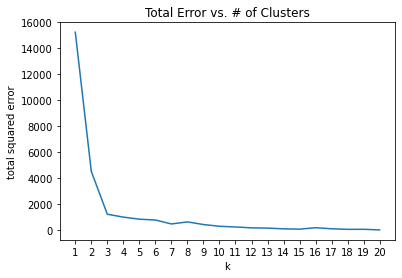

In [12]:
# 첫 번째부터 len(inputs)번째 군집까지 시각화
ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]

plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.title("Total Error vs. # of Clusters")
# plt.show()

위의 그림에서 우리가 눈으로 어림잡은 군집 수인 세 개가 '알맞은' 군집 수였다는 것을 확인할 수 있다.

## 20.5 예시: 색 군집화하기
스티커 굿즈를 만드는데 프린터는 총 다섯가지 색밖에 출력할 수가 없다. 

이미지 파일은 보통 픽셀의 2차원 배열이고, 픽셀은 새을 나타내는 (Red, Green, Blue)로 구성된 3차원 벡터이다.
이 것을 다섯 가지 색의 이미지로 바꾼다은 것은 다음의 과정을 의미한다.

1. 다섯 가지 색을 고른다.
2. 각 픽셀을 다섯 가지 색 중 하나로 매핑한다.

이 문제는 k-means로 풀기에 적당한 형태이다. k-means를 사용하면 RGB 공간상에서 모든 픽셀을 다섯 개의 군집으로 나눌 수 있다. 그 다음에 각 픽셀을 각 군집의 중점색으로 칠하면 된다.

In [13]:
# %pip install pillow

In [14]:
image_path = r"girl_with_book.jpg"  # 이미지가 있는 경로
import matplotlib.image as mpimg 
img = mpimg.imread(image_path) / 256  # 0과 1 사이로 매핑한다.

FileNotFoundError: [Errno 2] No such file or directory: 'girl_with_book.jpg'

사실 img는 Numpy 배열이지만, 여기서는 이를 리스트의 리스트의 리스트로 생각하자.

img[i][j] i행의 j번째 열의 픽셀이고, 각 픽셀은 색을 나타내도록 0부터 1사이의 [red, green, blue] 값을 가진다.

In [15]:
top_row = img[0]
top_left_pixel = top_row[0]
red, green, blue = top_left_pixel

NameError: name 'img' is not defined

행과 열에 무관하게 전체 픽셀에 대한 리스트는 다음과 같이 나타낼 수 있다.

In [16]:
# .tolist()는 Numpy 배열을 파이썬 리스트로 변환한다.
pixels = [pixel.tolist() for row in img for pixel in row]

NameError: name 'img' is not defined

이를 군집화 알고리즘에 넣어 보자.

In [17]:
clusterer = KMeans(5)
clusterer.train(pixels)  # 시간이 오래 걸릴 수도 있다.

NameError: name 'pixels' is not defined

알고리즘을 돌리고 나면 새로운 이미지가 생성된다.

In [18]:
def recolor(pixel: Vector) -> Vector:
    cluster = clusterer.classify(pixel)  # 가장 가까운 군집의 인덱스
    return clusterer.means[cluster]  # 가장 가까운 군집의 중심점

In [19]:
new_img = [[recolor(pixel) for pixel in row]  # 주어진 행의 픽셀을 다시 칠하자.
          for row in img]  # 이미지의 모든 행에 대해

NameError: name 'img' is not defined

plt.imshow로 이미지를 출력할 수 있다.

In [20]:
plt.imshow(new_img)
plt.axis('off')
plt.show()

NameError: name 'new_img' is not defined

## 20.6 상향식 계층 군집화
군집화를 할 수 있는 다른 방법으로는 상향식으로 군집들을 묶는 방법이 있다. 아래와 같은 방법으로 진행한다.

1. 각 데이터 포인트를 하나의 군집으로 간주한다.
2. 군집이 두 개 이상이라면 가장 가까운 두 개의 군집을 찾아 하나의 군집으로 묶는다. 

위의 반복 연산이 완전히 종료되면 최종적으로 단 하나의 거대한 군집만이 남는다. 다만, 군집들을 묶어 나가는 중간 과정을 모두 기록해 두기 때문에, 언제든 묶인 군집을 다시 풀 수 있다. 

e.g. 세 개의 군집을 원한다면 마지막 두 번의 병합만 되돌리면 된다.

군집을 표현할 때는 간단한 표기법을 쓰자. 데이터 값은 NamedTuple로 표현된 잎(leaf) 군집에 넣도록 하자.

In [21]:
from typing import NamedTuple, Union

class Leaf(NamedTuple):
    value: Vector
        
leaf1 = Leaf([10, 20])
leaf2 = Leaf([30, -15])

이를 이용해 역시 NamedTuple로 표현되는 병합된 군집을 만들 것이다.

In [39]:
class Merged(NamedTuple):
    children: tuple
    order: int

In [40]:
merged = Merged((leaf1, leaf2), order=1)

Cluster = Union[Leaf, Merged]

아래 코드는 군집에 포함된 값들을 모두 반환하는 함수

In [41]:
def get_values(cluster: Cluster) -> List[Vector]:
    if isinstance(cluster, Leaf):
        return [cluster.value]
    
    else:
        return [value
               for child in cluster.children
               for value in get_values(child)]

In [42]:
assert get_values(merged) == [[10,20], [30, -15]]

가장 가까운 두 개의 군집을 묶기 위해서는 군집 간 거리를 먼저 정의할 수 있어야 한다. 여기서는 두 군집 간의 최소 거리를 사용해서 군집화를 할 것인데, 이는 서로 경계면이 가장 가깝게 맞닿아 있는 군집끼리 묶겠다는 것을 의미한다. (이렇게 하면 막상 가깝지 않으면서 체인처럼 이어진 형태의 군집이 생성되기도 한다.) 구형의 군집을 만들고 싶은 경우, 두 군집 간의 최대 거리를 사용하면 된다. 이 두 가지의 접근법 외에 평균 거리도 자주 사용된다.

In [43]:
import math
from typing import Callable

def subtract(v: Vector, w: Vector) -> Vector:
    """각 성분끼리 뺀다."""
    assert len(v) == len(w), "vectors must be the same length"
    
    return [v_i - w_i for v_i, w_i in zip(v, w)]

def dot(v: Vector, w: Vector) -> float:
    """v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w),  "vectors must be same length"
    
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

def sum_of_squares(v: Vector) -> float:
    """v_1 * v_1 + ... v_n * v_n"""
    return dot(v,v)

def squared_distance(v: Vector, w: Vector) -> float:
    """(v_1 - w_1)**2 + ... + (v_n - w_n)**2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """벡터 v와 w 간의 거리를 계산"""
    return math.sqrt(squared_distance(v,w))

In [44]:
def cluster_distance(cluster1: Cluster,
                    cluster2: Cluster,
                    distance_agg: Callable = min) -> float:
    """
    cluster1에 속하는 점과 cluster2에 속하는 점 사이의 모든 거리를 계산하고
    결과로 나오는 리스트에 distance_agg를 적용
    """
    return distance_agg([distance(v1, v2)
                        for v1 in get_values(cluster1)
                        for v2 in get_values(cluster2)])

**병합 순서는 우리가 어떤 순서로 병합을 했는지 파악하고, 이를 다시 분해하기 위해 필요하다.**

숫자가 작을수록 나중에 병합했다는 것을 의미한다. 즉, 병합한 것을 다시 분해하고 싶을 때, 병합 순서가 낮은 것부터 높은 것까지 순차적으로 살펴보면 된다. 잎 군집은 한 번도 병합된 적이 없으니, 그들의 병합 순서는 무한대로 정한다. 그리고 잎 군집에는 .order 속성이 없으므로 함수도 하나 만들어주자.

In [54]:
def get_merge_order(cluster: Cluster) -> float:
    if isinstance(cluster, Leaf):
        return float('inf')  # 한 번도 병합된 적이 없다. 
    else: 
        return cluster.order

잎 군집에는 자식도 없으므로, 그에 대응하는 함수도 만들자.

In [55]:
from typing import Tuple
def get_children(cluster: Cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Leaf has no children")
        
    else:
        return cluster.children

위의 모든 코드들을 작서하였고 이제 군집화 알고리즘을 작성할 준비가 다 되었다.

In [56]:
def bottom_up_cluster(inputs: List[Vector],
                     distance_agg: Callable = min) -> Cluster:
    # 모든 잎으로 시작한다.
    clusters: List[Cluster] = [Leaf(input) for input in inputs]
        
    def pair_distance(pair: Tuple[Cluster, Cluster]) -> float:
        return cluster_distance(pair[0], pair[1], distance_agg)
    
    # 한 개 이상의 군집이 존재한다면...
    while len(clusters) > 1: 
        # 가장 가까운 두 개의 군집을 찾아
        c1, c2 = min(((cluster1, cluster2)
                    for i, cluster1 in enumerate(clusters)
                    for cluster2 in clusters[:i]),
                    key=pair_distance)
        
        # 군집의 리스트에서 제거한다.
        clusters = [c for c in clusters if c != c1 and c != c2]
        
        # (order=남은 군집의 수)로 두 군집을 병합하고
        merged_cluster = Merged((c1, c2), order=len(clusters))
        
        # 병합된 군집을 추가
        clusters.append(merged_cluster)
        
    # 군집이 하나 밖에 남지 않은 경우 반환
    return clusters[0]

사용 방법은 간단하다.

In [57]:
base_cluster = bottom_up_cluster(inputs)

In [58]:
base_cluster

Merged(children=(Merged(children=(Merged(children=(Merged(children=(Merged(children=(Leaf(value=[19, 28]), Leaf(value=[21, 27])), order=18), Leaf(value=[20, 23])), order=14), Leaf(value=[26, 13])), order=3), Merged(children=(Leaf(value=[11, 15]), Leaf(value=[13, 13])), order=16)), order=1), Merged(children=(Merged(children=(Merged(children=(Merged(children=(Merged(children=(Leaf(value=[-49, 0]), Leaf(value=[-46, 5])), order=11), Leaf(value=[-41, 8])), order=9), Leaf(value=[-49, 15])), order=5), Leaf(value=[-34, -1])), order=4), Merged(children=(Merged(children=(Merged(children=(Merged(children=(Leaf(value=[-22, -16]), Leaf(value=[-19, -11])), order=10), Leaf(value=[-25, -9])), order=8), Merged(children=(Merged(children=(Merged(children=(Leaf(value=[-11, -6]), Leaf(value=[-12, -8])), order=17), Leaf(value=[-14, -5])), order=15), Leaf(value=[-18, -3])), order=13)), order=7), Merged(children=(Leaf(value=[-13, -19]), Leaf(value=[-9, -16])), order=12)), order=6)), order=2)), order=0)

최상단에 있는 숫자들은 병합된 숫자를 일컫는다. 20개의 입력값을 받았으므로, 거대한 군집 하나를 얻는 데 19번의 병합을 했다. 첫 번째 병합에서는 잎 [19, 28]과 잎[21, 27]을 합쳐서 군집 18을 만들었다. 마지막 병합에서 군집 0을 만들었다.

두 개의 군집만 원한다면 첫번째 분기('0')에서 6개 데이터 포인트가 있는 군집 하나와 나머지로 구성된 군집으로 나눌 것이다. 세 개의 군집을 원한다면 두 번째 분기('1')에서 한 번 더 나눠서, 첫 번재 군집이 ([19, 28], [21, 27], [20, 23], [26, 13])과 ([11, 15], [13, 13])으로 나뉘도록 할 것이다. 더 많은 군집을 원한다면 이 방식을 반복하면 된다.

하지만 보통 이렇게 텍스트로 지저분하게 나열된 것을 눈을 찡그리며 보고 싶지는 않을 것이다. 대신, 특정 개수의 군집을 원할 대 필요한 만큼 분해를 해서 군집을 반환해 주는 함수를 만들어 보자.

In [59]:
def generate_clusters(base_cluster: Cluster,
                     num_cluster: int) -> List[Cluster]:
    # 주어진 군집이 들어있는 리스트로 시작
    clusters = [base_cluster]
    
    # 군집의 개수가 충분하지 않은 동안
    while len(clusters) < num_cluster:
        # 가장 마지막으로 병합된 군지븡ㄹ 선택
        next_cluster = min(clusters, key=get_merge_order)
        # 목록에서 제거하고
        clusters = [c for c in clusters if c != next_cluster]
        
        # 자식 군집을 목록에 추가(즉, 병합을 풀어 줌)
        clusters.extend(get_children(next_cluster))
        
    # 군집의 개수가 충분하면 반환
    return clusters

예를 들어 세 개의 군집을 만들고 싶다면 다음과 같이 처리해서

In [60]:
three_clusters = [get_values(cluster)
                 for cluster in generate_clusters(base_cluster, 3)]

다음과 같이 쉽게 시각화할 수 있다.

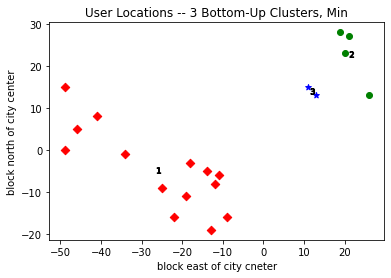

In [63]:
for i, cluster, marker, color in zip([1,2,3],
                                    three_clusters,
                                    ['D', 'o', '*'],
                                    ['r', 'g', 'b']):
    xs, ys = zip(*cluster)  # 마법 같은 unzip 기능
    plt.scatter(xs, ys, color=color, marker=marker)
    
    # 군집의 중심점에 숫자를 표기
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')
    
plt.title("User Locations -- 3 Bottom-Up Clusters, Min")
plt.xlabel("block east of city cneter")
plt.ylabel("block north of city center")
plt.show()

이렇게 하면 k-means와는 꽤 다른 결과를 얻게 된다.

최소 거리를 이용한 계층 군집화는 일반적으로 체인 형태의 결과물을 반환하기 때문이다. 만일 최대 거리를 이용했다면 3-means와 비슷한 결과를 얻었을 것이다.

Text(0, 0.5, 'blocks north of city center')

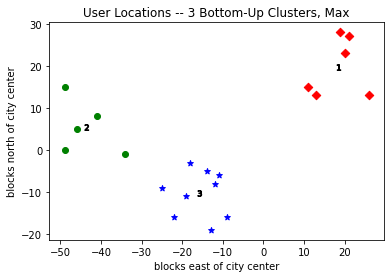

In [64]:
base_cluster_max = bottom_up_cluster(inputs, max)
three_clusters_max = [get_values(cluster)
                      for cluster in generate_clusters(base_cluster_max, 3)]

for i, cluster, marker, color in zip([1, 2, 3],
                                     three_clusters_max,
                                     ['D','o','*'],
                                     ['r','g','b']):
    xs, ys = zip(*cluster)  # magic unzipping trick
    plt.scatter(xs, ys, color=color, marker=marker)

    # put a number at the mean of the cluster
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title("User Locations -- 3 Bottom-Up Clusters, Max")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")